In [1]:
import os
import time
from functools import partial
import numpy as np
import pandas as pd

import plotly.offline as py
import plotly.graph_objs as go
import plotly.io

In [2]:
def mock_data(rows=1):
    data = {
        'datetime': pd.date_range(start='2018-01-01', freq='1s', periods=rows),
        'a': np.random.randn(rows),
        'b': np.random.randn(rows),
        'c': np.random.randn(rows),
        'd': np.random.randn(rows),
        'e': np.random.randn(rows),
        'f': np.random.randn(rows)
    }
    return pd.DataFrame(data)

## Define formats

In [3]:
def hdf_writer(format='fixed', compression=None):
    def writer(df, filename):
        pd.DataFrame.to_hdf(
            df, filename, 
            key='key',
            format=format,
            complib=compression
    )
    return writer


def parquet_writer(compression=None):
    def writer(df, filename):
        pd.DataFrame.to_parquet(
            df, filename, 
            compression=compression,
    )
    return writer


formats = [
    dict(name='csv', reader=pd.read_csv, writer=pd.DataFrame.to_csv),
    dict(name='hdf-fixed', reader=pd.read_hdf, writer=hdf_writer('fixed')),
    dict(name='hdf-table', reader=pd.read_hdf, writer=hdf_writer('table')),
    dict(name='hdf-fixed-zlib', reader=pd.read_hdf, writer=hdf_writer('fixed', 'zlib')),
    dict(name='hdf-table-zlib', reader=pd.read_hdf, writer=hdf_writer('table', 'zlib')),
    dict(name='pq', reader=pd.read_parquet, writer=parquet_writer()),
    dict(name='pq-snappy', reader=pd.read_parquet, writer=parquet_writer('snappy')),
    dict(name='pq-gzip', reader=pd.read_parquet, writer=parquet_writer('gzip')),
]

In [7]:
def test_format(format, df=None):
    name, read, write = format['name'], format['reader'], format['writer']
    filename = f'temp.{name}'
    try:
        os.remove(filename)
    except FileNotFoundError:
        pass
    w_start = time.time()
    write(df, filename)
    w_end = r_start = time.time()
    df2 = read(filename)
    r_end = time.time()
    size = os.stat(filename).st_size
    result = {
        'format': name, 
        'rows': len(df), 
        'read_s': r_end - r_start,
        'write_s': w_end - w_start,
        'size_B': float(size),
        'size_kB': float(size / 2**10),
        'size_MB': float(size / 2**20)
    }
    return result

## Test on a small dataframe, incl. CSV

In [52]:
test_df = mock_data(1000000)

In [53]:
results = pd.DataFrame.from_records(
    test_format(fmt, df=test_df) for fmt in formats
)

In [57]:
results = results.sort_values(by='read_s', ascending=False)
results

,format,read_s,rows,size_B,size_MB,size_kB,write_s
0,csv,2.020035,1000000,144674192.0,137.972061,141283.390625,10.800319
2,hdf-table,0.168685,1000000,64447940.0,61.462345,62937.441406,0.615951
4,hdf-table-zlib,0.158608,1000000,64447940.0,61.462345,62937.441406,0.605204
7,pq-gzip,0.084014,1000000,52192737.0,49.774873,50969.469727,2.877942
6,pq-snappy,0.062976,1000000,59258783.0,56.513579,57869.905273,0.420174
5,pq,0.039006,1000000,66236886.0,63.168417,64684.458984,0.227964
3,hdf-fixed-zlib,0.028837,1000000,64009288.0,61.044014,62509.070312,0.050708
1,hdf-fixed,0.028090,1000000,64009288.0,61.044014,62509.070312,0.072720


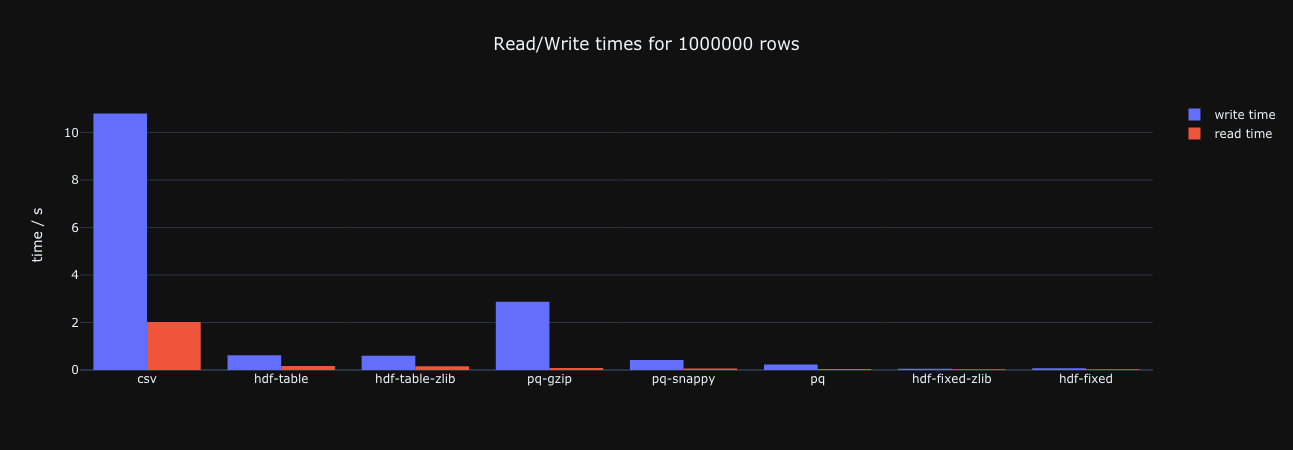

In [58]:
data = [
    go.Bar(
        x=results['format'],
        y=results['write_s'],
        name='write time'
    ),
    go.Bar(
        x=results['format'],
        y=results['read_s'],
        name='read time'   
    ),
]

layout = go.Layout(
    title=f'Read/Write times for {len(test_df)} rows',
    yaxis = dict(
        title='time / s',
        hoverformat='.1f'
    ),
    template='plotly_dark'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

In [59]:
plotly.io.write_json(fig, 'read_write_bar.json')

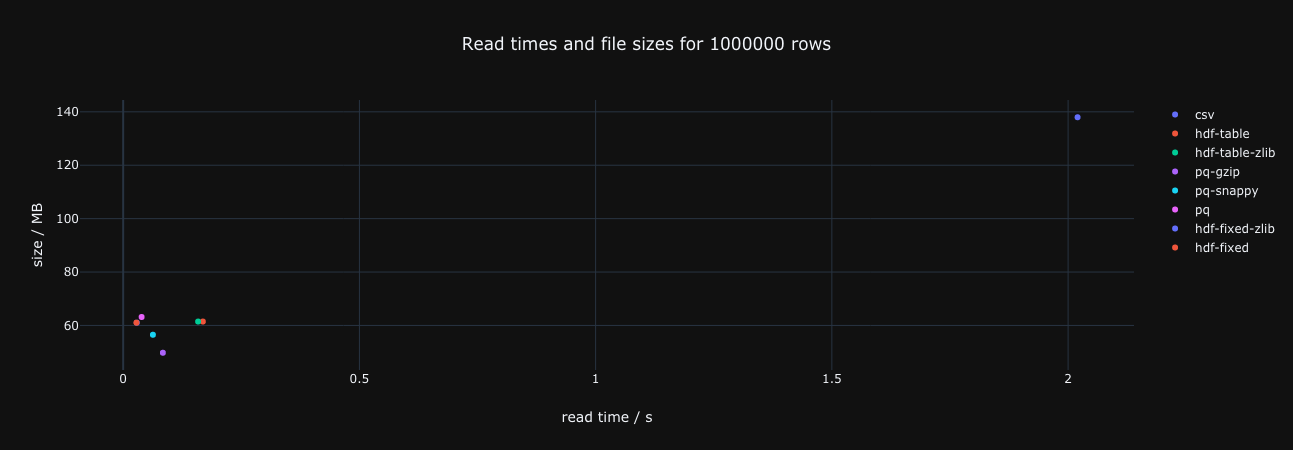

In [61]:
data = [
    go.Scatter(
        x=[result['read_s']],
        y=[result['size_MB']],
        text=[result['format']],
        name=result['format'],
        mode='markers',
        hoverinfo='text+x+y'
    ) for _, result in results.iterrows()
]

layout = go.Layout(
    title=f'Read times and file sizes for {len(test_df)} rows',
    xaxis = dict(
        title='read time / s',
        hoverformat='.1f'
    ),
    yaxis = dict(
        title='size / MB',
        hoverformat='.1f'
    ),
    hovermode='closest',
    template='plotly_dark'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

In [62]:
plotly.io.write_json(fig, 'read_size.json')

## Test on a larger dataframe, excl. CSV

In [8]:
test_df = mock_data(int(10e6))

In [9]:
results = pd.DataFrame.from_records(
    test_format(fmt, df=test_df) for fmt in formats[1:]
)

In [10]:
results = results.sort_values(by='read_s', ascending=False)
results

,format,read_s,rows,size_B,size_MB,size_kB,write_s
1,hdf-table,1.399473,10000000,642093870.0,612.348433,627044.794922,6.034470
3,hdf-table-zlib,1.353010,10000000,642093870.0,612.348433,627044.794922,5.772946
6,pq-gzip,0.693314,10000000,503022045.0,479.719205,491232.465820,26.842992
5,pq-snappy,0.608957,10000000,572487793.0,545.966905,559070.110352,3.053591
4,pq,0.340507,10000000,642268407.0,612.514884,627215.241211,1.348265
0,hdf-fixed,0.277852,10000000,640009288.0,610.360420,625009.070312,1.180792
2,hdf-fixed-zlib,0.276346,10000000,640009288.0,610.360420,625009.070312,0.892142


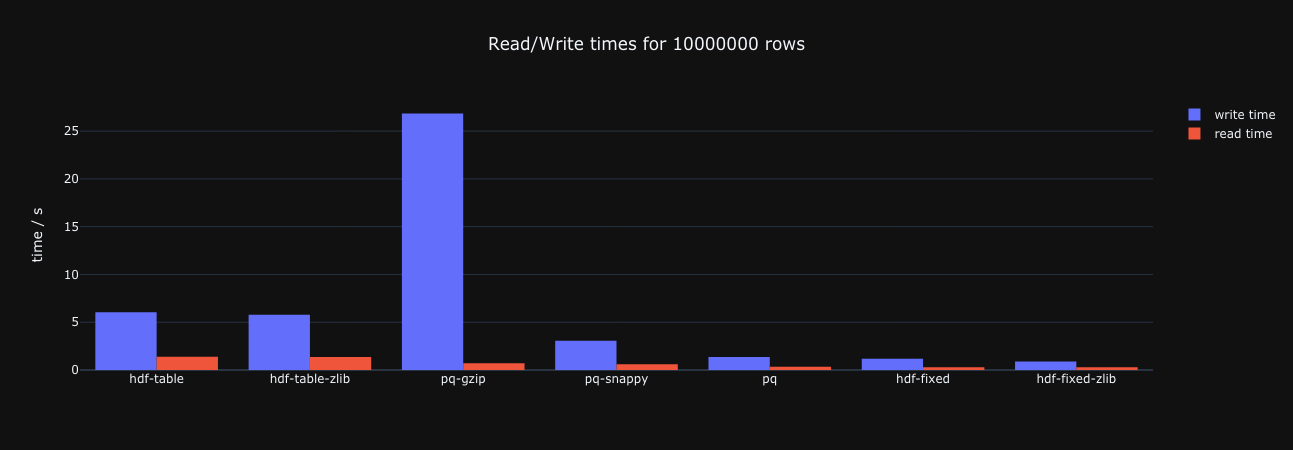

In [11]:
data = [
    go.Bar(
        x=results['format'],
        y=results['write_s'],
        name='write time'
    ),
    go.Bar(
        x=results['format'],
        y=results['read_s'],
        name='read time'   
    ),
]

layout = go.Layout(
    title=f'Read/Write times for {len(test_df)} rows',
    yaxis = dict(
        title='time / s',
        hoverformat='.1f'
    ),
    template='plotly_dark'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

In [12]:
plotly.io.write_json(fig, 'large_read_write_bar.json')

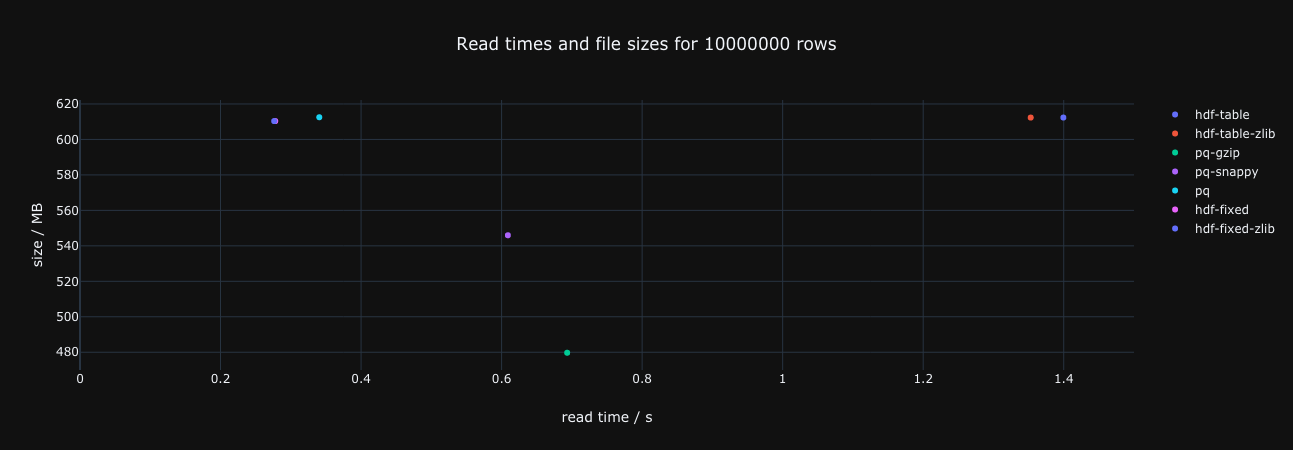

In [50]:
data = [
    go.Scatter(
        x=[result['read_s']],
        y=[result['size_MB']],
        text=[result['format']],
        name=result['format'],
        mode='markers',
        hoverinfo='text+x+y'
    ) for _, result in results.iterrows()
]

layout = go.Layout(
    title=f'Read times and file sizes for {len(test_df)} rows',
    xaxis = dict(
        title='read time / s',
        hoverformat='.1f',
        range=[0, 1.5]
    ),
    yaxis = dict(
        title='size / MB',
        hoverformat='.1f'
    ),
    hovermode='closest',
    template='plotly_dark'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

In [51]:
plotly.io.write_json(fig, 'large_read_size.json')